# Index of nearest value
The core of timewizard's functionality is built around `index_of_nearest_value`. The idea is simple: for each event time, find the closest time in the data.

This notebook uses toy examples to show how to work with timewizard's core peri-event functionality.

In [1]:
import numpy as np
import timewizard.perievent as tw
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
tw.index_of_nearest_value(np.arange(10), [5.01, 6.2])

array([5, 6])

This simple idea can simplify and streamline lots of timeseries analyses. For example, say you observed an animal's position with a camera recording 30 Hz video, while capturing some other events in other data streams (say, vocalizations). You want to know what the animal's position was across all of its vocalizations.

First, let's make up some data. Let's say the animal mostly ran in circles.

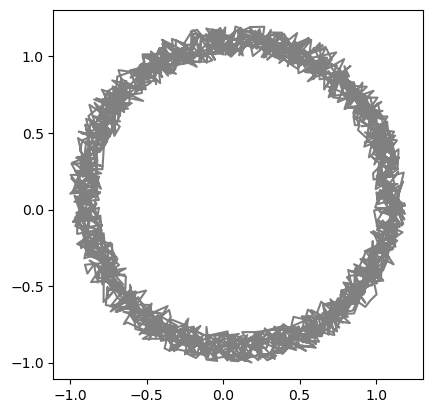

In [3]:
np.random.seed(10)

fs = 30  # Hz
t = np.arange(0, 20*np.pi, 1/fs)  
x = np.cos(t) + np.random.random(t.shape) * 0.2
y = np.sin(t) + np.random.random(t.shape) * 0.2
data = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
plt.plot(data[:,0], data[:,1], color='gray')
_ = plt.axis('square')

Vocalizations occured at points close to halfway around the circle.

In [4]:
n_evts = 6
evt_times = np.random.choice(np.arange(np.pi, 20*np.pi, 2*np.pi) + (0.5 - np.random.random(10)), size=n_evts, replace=False)

If all you need to know is where the animal was when it vocalized, then you can just interpolate the data.

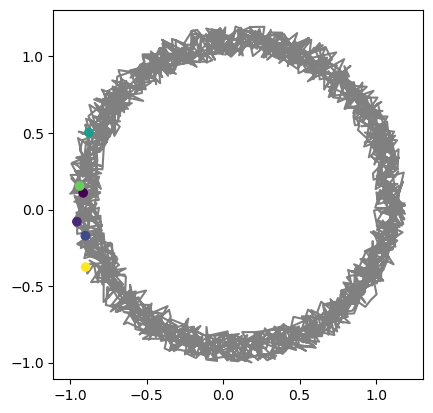

In [5]:
evt_postions = tw.map_values(t, data, evt_times, interpolate=True)
plt.plot(data[:,0], data[:,1], 'gray')
plt.scatter(evt_postions[:,0], evt_postions[:,1], c=evt_times, zorder=np.inf)
_ = plt.axis('square')

However, a harder problem is generating an array of the animal's peri-event positions. For example, say you wanted to look at the animal's position from 1 second before to 1 second after each vocalization. There are two strategies you could use:
1. for each event, generate an array of evenly-sampled timestamps relative to the actual event, and interpolate the data to match those timestamps exactly.
2. for each event, grab a window of the raw (uninterpolated) data that matches your window of interest as closely as possible.

In general, #1 is overkill, unless you need the data to be re-sampled at a particular sampling rate; but #2 is a hassle to code up. 

Happily, `timewizard` wraps option #2 in a succinct function for you. The core of this function is `index_of_nearest_value` -- the starting and ending points of the returned traces are as close as possible to the requested window around the event, while only using the original data.

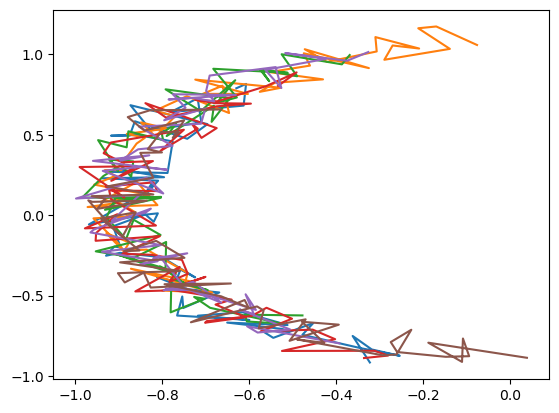

In [6]:
peritimes, traces = tw.perievent_traces(t, data, evt_times, time_window=(-1,1), fs=fs)
for iEvt in range(traces.shape[0]):
    plt.plot(traces[iEvt, :, 0], traces[iEvt, :, 1])